# **Multi-inference implicit chain of reasoning (no teacher) demonstration**

In this notebook I attempt to solve this challenge [here](https://yuntiandeng.com/cv/challenge.png) by referencing the research paper and source code linked below. We are are trying to create a LLM that can solve simultaneous 2 digit by 2 digit multiplication using implicit chain of thought reasoning. **Instead of using a teacher model, I have the emulators use the actual pure CoT to accomplish similar implicit reasoning via teacher states.**

| ||
|----------|----------|
| Research Credit | [here](https://arxiv.org/pdf/2311.01460.pdf) |
| Code Inspiration Credit | [github](https://github.com/da03/implicit_chain_of_thought/tree/main) |

- We train a thought emulator model to predict pure CoT from input. 
- We have a mind reader emulator that predicts the final output from pure CoT.
- Finally we create the implicit student model, which trains using pre-trained thought and mindreader emulators simultaneously to implicity use pure CoT to predict the output from the input.

In [1]:
import sys
import os

#For safe imports of everything
notebook_directory = os.getcwd()
parent_directory = os.path.dirname(notebook_directory)
sys.path.insert(False, parent_directory)

### **Dataset Generation**
Here we generate our test and train data. We generate our training data randomly such that it represents less than **1%** of possible observations. We also generate our tokenized data automatically here as well.

---

The format of training and test datasets follow this format:

```
[input 1a] $ [input 1b]||[CoT 1a] $ [CoT 1b] #### [output 1a] $ [output 1b]
[input 2a] $ [input 2b]||[CoT 2a] $ [CoT 2b] #### [output 2a] $ [output 2b]
[input 3a] $ [input 3b]||[CoT 3a] $ [CoT 3b] #### [output 3a] $ [output 3b]
```

We can also test any particular case using the DatasetHandler so we create a custom prediction dataset as well.

**NOTE** The `DatasetHandler` class has a method `generateDataset`, which may be used to create new randomly generated datasets.

In [2]:
from data.data import DatasetHandler

training_data_size = 7770
test_data_size = 770

datahandler_train = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'train')
datahandler_test = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'test')

Now we read datasets for each handler. There is also code to generate a new dataset with the same size used in this demo.

In [3]:
datahandler_train.generateDataset(size = training_data_size)

#datahandler_train.readDataset()

Generated raw train dataset saved at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_train_dataset.txt of size 777000.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_train_dataset.txt
tgt_avg:  20.0
src_avg:  12.0
ratios:  0.6
tgt_avg:  14.0
src_avg:  12.0
ratios:  0.8571428571428571
---------------------------
Example features:
Full entry:  1 2 * 4 6 $ 9 8 * 3 4 <|endoftext|> 4 8 0 + 0 6 2 1 $ 7 6 2 + 0 6 5 3 <|endoftext|> #### 4 4 3 1 $ 7 2 8 3 <|endoftext|>
No CoT:  1 2 * 4 6 $ 9 8 * 3 4 <|endoftext|> #### 4 4 3 1 $ 7 2 8 3 <|endoftext|>
Only CoT:  1 2 * 4 6 $ 9 8 * 3 4 <|endoftext|> 4 8 0 + 0 6 2 1 $ 7 6 2 + 0 6 5 3 <|endoftext|>
Product input:  1 2 * 4 6 $ 9 8 * 3 4 <|endoftext|> 
Pure CoT input:  1 2 * 4 6 $ 9 8 * 3 4 <|endoftext|> 4 8 0 + 0 6 2 1 $ 7 6 2 + 0 6 5 3 <|endoftext|>
Pure CoT output:  4 8 0 + 0 6 2 1 $ 7 6 2 + 0 6 5 3 <|endoftext|> #### 4 4 3 1 $ 7 2 8 3 <|endoftext|>
---------------------------


In [4]:
datahandler_test.generateDataset(size = test_data_size)

#datahandler_test.readDataset()

Generated raw test dataset saved at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_test_dataset.txt of size 77000.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_test_dataset.txt
tgt_avg:  20.0
src_avg:  12.0
ratios:  0.6
tgt_avg:  14.0
src_avg:  12.0
ratios:  0.8571428571428571
---------------------------
Example features:
Full entry:  2 1 * 1 8 $ 9 7 * 2 0 <|endoftext|> 2 1 0 + 0 6 9 0 $ 8 5 1 + 0 0 0 0 <|endoftext|> #### 2 7 9 0 $ 8 5 1 0 <|endoftext|>
No CoT:  2 1 * 1 8 $ 9 7 * 2 0 <|endoftext|> #### 2 7 9 0 $ 8 5 1 0 <|endoftext|>
Only CoT:  2 1 * 1 8 $ 9 7 * 2 0 <|endoftext|> 2 1 0 + 0 6 9 0 $ 8 5 1 + 0 0 0 0 <|endoftext|>
Product input:  2 1 * 1 8 $ 9 7 * 2 0 <|endoftext|> 
Pure CoT input:  2 1 * 1 8 $ 9 7 * 2 0 <|endoftext|> 2 1 0 + 0 6 9 0 $ 8 5 1 + 0 0 0 0 <|endoftext|>
Pure CoT output:  2 1 0 + 0 6 9 0 $ 8 5 1 + 0 0 0 0 <|endoftext|> #### 2 7 9 0 $ 8 5 1 0 <|endoftext|>
---------------------------


Here we allow the creation of a **custom prediction** using input from the jupyter kernel, press enter after each integer. The custom prediction is of the form **a*b** and **c*d**.

In [6]:
#Please provide inputs for the custom test case. Press enter after each integer.
a= int(input("provide int a: "))
b= int(input("provide int b: "))
c= int(input("provide int c: "))
d= int(input("provide int d: "))

print(f"You have provided the input {a}*{b} and {c}*{d} which equals {a*b} and {c*d} respectively.")

custom_prediction = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'custom')
custom_prediction.generateDataset(a=a, b=b, c=c, d=d)

You have provided the input 13*96 and 73*21 which equals 1248 and 1533 respectively.
Generated raw custom dataset saved at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_custom_dataset.txt of size 1.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_custom_dataset.txt
tgt_avg:  20.0
src_avg:  12.0
ratios:  0.6
tgt_avg:  14.0
src_avg:  12.0
ratios:  0.8571428571428571
---------------------------
Example features:
Full entry:  3 1 * 6 9 $ 3 7 * 1 2 <|endoftext|> 8 7 0 + 0 7 1 1 $ 3 7 0 + 0 6 4 1 <|endoftext|> #### 8 4 2 1 $ 3 3 5 1 <|endoftext|>
No CoT:  3 1 * 6 9 $ 3 7 * 1 2 <|endoftext|> #### 8 4 2 1 $ 3 3 5 1 <|endoftext|>
Only CoT:  3 1 * 6 9 $ 3 7 * 1 2 <|endoftext|> 8 7 0 + 0 7 1 1 $ 3 7 0 + 0 6 4 1 <|endoftext|>
Product input:  3 1 * 6 9 $ 3 7 * 1 2 <|endoftext|> 
Pure CoT input:  3 1 * 6 9 $ 3 7 * 1 2 <|endoftext|> 8 7 0 + 0 7 1 1 $ 3 7 0 + 0 6 4 1 <|endoftext|>
Pure CoT output:  8 7 0 + 0 7 1 1 $ 3 7 0 + 0 6 4 1 <|endoftext

### **Model Training**
Here we begin training our individual models. First we import everything we need.

---


In [7]:
from source.thought_emulator import ThoughtEmulator
from source.configurations import ThoughtEmulatorConfig

from source.mindreading_emulator import MindReadingEmulator
from source.configurations import MindReadingEmulatorConfig

from source.implicit_student import ImplicitStudent

Now we initialize the configurations and models.

In [8]:
t_emulator_config = ThoughtEmulatorConfig()
t_emulator_model = ThoughtEmulator(t_emulator_config)

mr_emulator_config = MindReadingEmulatorConfig()
mr_emulator_model = MindReadingEmulator(mr_emulator_config)

implicit_model = ImplicitStudent(mr_emulator_config, mindread = mr_emulator_model, thought = t_emulator_model)

##### **Thought Emulator Model**
This model takes the input and predicts the pure CoT.

  0%|          | 1/24282 [00:04<31:41:27,  4.70s/it]

Step: 0. PPL: 82.330002. Training Accuracy: 0.152961


 10%|█         | 2430/24282 [10:56<1:41:25,  3.59it/s]

Step: 2429. PPL: 1.004648. Training Accuracy: 0.998355


 20%|██        | 4859/24282 [21:21<1:27:23,  3.70it/s]

Step: 4858. PPL: 1.001310. Training Accuracy: 1.000000


 30%|███       | 7288/24282 [31:03<1:06:38,  4.25it/s]

Step: 7287. PPL: 1.000148. Training Accuracy: 1.000000


 40%|████      | 9717/24282 [41:04<57:18,  4.24it/s]  

Step: 9716. PPL: 1.000137. Training Accuracy: 1.000000


 50%|█████     | 12146/24282 [50:44<47:54,  4.22it/s]  

Step: 12145. PPL: 1.000024. Training Accuracy: 1.000000


 60%|██████    | 14575/24282 [1:00:43<40:36,  3.98it/s]

Step: 14574. PPL: 1.000054. Training Accuracy: 1.000000


 70%|███████   | 17004/24282 [1:10:37<28:30,  4.26it/s]

Step: 17003. PPL: 1.000106. Training Accuracy: 1.000000


 80%|████████  | 19433/24282 [1:20:40<21:21,  3.78it/s]

Step: 19432. PPL: 1.000077. Training Accuracy: 1.000000


 90%|█████████ | 21862/24282 [1:30:34<10:40,  3.78it/s]

Step: 21861. PPL: 1.000011. Training Accuracy: 1.000000


100%|██████████| 24282/24282 [1:40:43<00:00,  4.02it/s]


✔ Evaluating test dataset now...


100%|██████████| 2407/2407 [11:10<00:00,  3.59it/s]

Input:  4 3 * 4 2 $ 3 0 * 9 9 
Target:  6 3 1 + 0 8 6 0 $ 7 2 0 + 0 7 2 0 
Predicted:  6 3 1 + 0 8 6 0 $ 7 2 0 + 0 7 2 0

Input:  2 3 * 6 8 $ 8 6 * 0 6 
Target:  2 9 1 + 0 6 5 2 $ 0 0 0 + 0 8 0 4 
Predicted:  2 9 1 + 0 6 5 2 $ 0 0 0 + 0 8 0 4

Input:  2 1 * 7 2 $ 6 4 * 1 1 
Target:  4 8 0 + 0 4 2 0 $ 6 4 0 + 0 6 4 0 
Predicted:  4 8 0 + 0 4 2 0 $ 6 4 0 + 0 6 4 0

→ PPL: 1.000001; Test Accuracy: 0.999987; Training Accuracy: 0.999999.
Saving to c:\Users\Luke\multi_implicit_cot_noteacher\models\thought_emulator


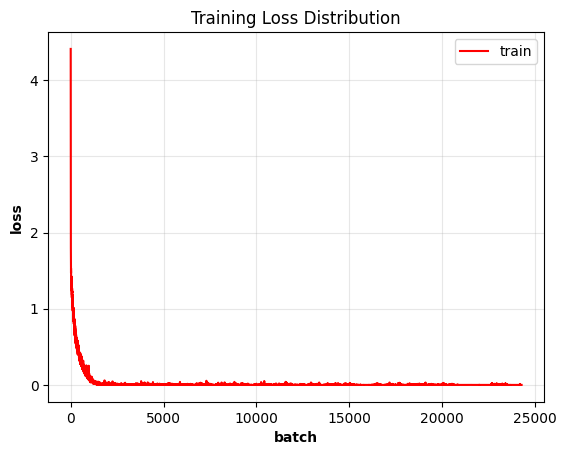

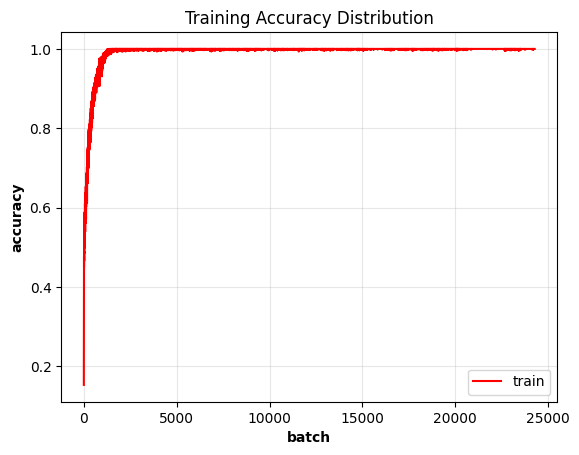

In [9]:
t_emulator_model.trainModel(train_handler = datahandler_train, test_handler = datahandler_test, limit = 1)

##### **Mind Reading Emulator Model**
This model takes in the pure CoT as input and predicts the output.

  0%|          | 1/24282 [00:00<1:46:56,  3.78it/s]

Step: 0. PPL: 184.561951. Training Accuracy: 0.149671


 10%|█         | 2430/24282 [09:40<1:25:22,  4.27it/s]

Step: 2429. PPL: 1.314968. Training Accuracy: 0.906250


 20%|██        | 4859/24282 [19:59<1:15:54,  4.26it/s]

Step: 4858. PPL: 1.280298. Training Accuracy: 0.907895


 30%|███       | 7288/24282 [29:34<1:06:49,  4.24it/s]

Step: 7287. PPL: 1.272801. Training Accuracy: 0.902961


 40%|████      | 9717/24282 [39:09<57:17,  4.24it/s]  

Step: 9716. PPL: 1.226287. Training Accuracy: 0.925987


 50%|█████     | 12146/24282 [48:57<54:19,  3.72it/s] 

Step: 12145. PPL: 1.235076. Training Accuracy: 0.922697


 60%|██████    | 14575/24282 [58:31<38:07,  4.24it/s]

Step: 14574. PPL: 1.209332. Training Accuracy: 0.924342


 70%|███████   | 17004/24282 [1:08:03<28:36,  4.24it/s]

Step: 17003. PPL: 1.202766. Training Accuracy: 0.934211


 80%|████████  | 19433/24282 [1:17:35<19:01,  4.25it/s]

Step: 19432. PPL: 1.168998. Training Accuracy: 0.935855


 90%|█████████ | 21862/24282 [1:27:06<09:29,  4.25it/s]

Step: 21861. PPL: 1.163876. Training Accuracy: 0.937500


100%|██████████| 24282/24282 [1:36:35<00:00,  4.19it/s]


✔ Evaluating test dataset now...


100%|██████████| 2407/2407 [09:40<00:00,  4.14it/s]

Input:  6 3 1 + 0 8 6 0 $ 7 2 0 + 0 7 2 0 
Target:  #### 6 1 8 0 $ 7 9 2 0 
Predicted:  #### 6 1 8 0 $ 7 9 2 0 

Input:  2 9 1 + 0 6 5 2 $ 0 0 0 + 0 8 0 4 
Target:  #### 2 5 7 2 $ 0 8 0 4 
Predicted:  #### 2 5 7 2 $ 0 8 0 4 

Input:  4 8 0 + 0 4 2 0 $ 6 4 0 + 0 6 4 0 
Target:  #### 4 2 3 0 $ 6 0 5 0 
Predicted:  #### 4 2 3 0 $ 6 0 5 0 

→ PPL: 1.187181; Test Accuracy: 1.000000. Training Accuracy: 0.930523.
Saving to c:\Users\Luke\multi_implicit_cot_noteacher\models\thought_emulator


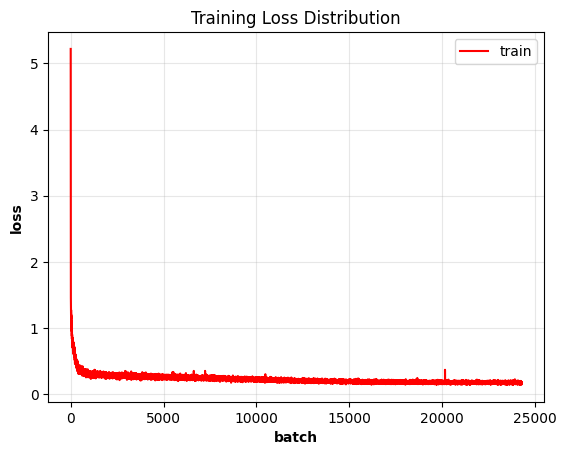

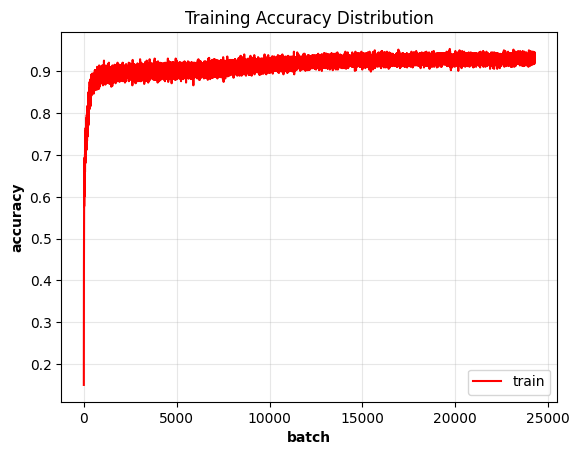

In [10]:
mr_emulator_model.trainModel(train_handler = datahandler_train, test_handler = datahandler_test, limit = 1)

##### **Implicit Model**
This model takes the input and predicts the pure CoT, and uses the pure CoT to predict the output. The pure CoT is used implicitly to mimic CoT reasoning internally. 

**NOTE** It trains using both a pretrained thought emulator and the mind emulator model, so make sure to train them in order.

  0%|          | 1/24282 [00:00<3:08:44,  2.14it/s]

Step: 0. CrossEntropyLoss: 11.058722. Training Accuracy: 0.288462.


 10%|█         | 2430/24282 [15:21<2:15:20,  2.69it/s]

Step: 2429. CrossEntropyLoss: 0.353056. Training Accuracy: 0.855769.


 20%|██        | 4859/24282 [31:04<2:01:56,  2.65it/s]

Step: 4858. CrossEntropyLoss: 0.026925. Training Accuracy: 0.992788.


 30%|███       | 7288/24282 [46:55<1:50:59,  2.55it/s]

Step: 7287. CrossEntropyLoss: 0.025893. Training Accuracy: 0.992788.


 40%|████      | 9717/24282 [1:02:47<1:35:57,  2.53it/s]

Step: 9716. CrossEntropyLoss: 0.016346. Training Accuracy: 0.997596.


 50%|█████     | 12146/24282 [1:18:37<1:19:21,  2.55it/s]

Step: 12145. CrossEntropyLoss: 0.000815. Training Accuracy: 1.000000.


 60%|██████    | 14575/24282 [1:34:21<1:06:38,  2.43it/s]

Step: 14574. CrossEntropyLoss: 0.002269. Training Accuracy: 1.000000.


 70%|███████   | 17004/24282 [1:50:31<51:18,  2.36it/s]  

Step: 17003. CrossEntropyLoss: 0.000403. Training Accuracy: 1.000000.


 80%|████████  | 19433/24282 [2:06:55<31:58,  2.53it/s]

Step: 19432. CrossEntropyLoss: 0.007428. Training Accuracy: 0.997596.


 90%|█████████ | 21862/24282 [2:22:29<15:00,  2.69it/s]

Step: 21861. CrossEntropyLoss: 0.000127. Training Accuracy: 1.000000.


100%|██████████| 24282/24282 [2:38:15<00:00,  2.56it/s]


✔ Evaluating test dataset now...


100%|██████████| 2407/2407 [15:56<00:00,  2.52it/s]

Input:  4 3 * 4 2 $ 3 0 * 9 9 
Target:  #### 6 1 8 0 $ 7 9 2 0 
Predicted:  #### 6 1 8 0 $ 7 9 2 0 

Input:  2 3 * 6 8 $ 8 6 * 0 6 
Target:  #### 2 5 7 2 $ 0 8 0 4 
Predicted:  #### 2 5 7 2 $ 0 8 0 4 

Input:  2 1 * 7 2 $ 6 4 * 1 1 
Target:  #### 4 2 3 0 $ 6 0 5 0 
Predicted:  #### 4 2 3 0 $ 6 0 5 0 

→ Perplexitity: 1.001552; Test Accuracy: 0.996429; Training Accuracy: 0.999696.
Saving to c:\Users\Luke\multi_implicit_cot_noteacher\models\implict_thought_emulator


Saving to c:\Users\Luke\multi_implicit_cot_noteacher\models\implict_mindreading_emulator


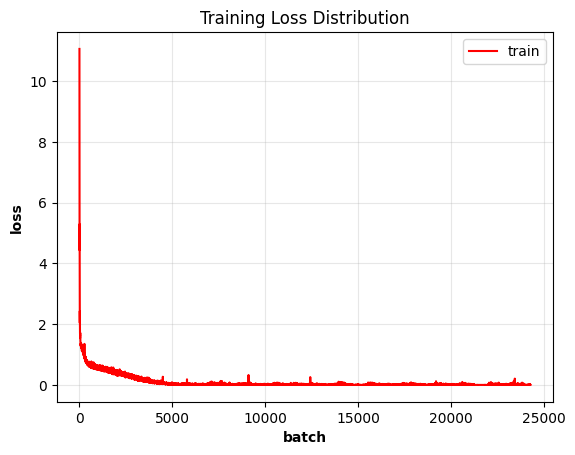

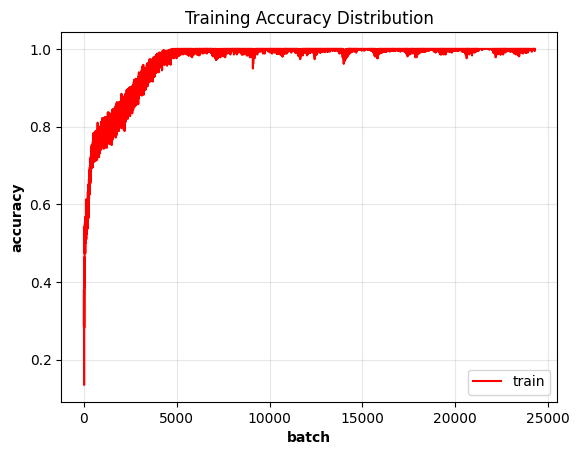

In [11]:
implicit_model.trainModel(train_handler = datahandler_train, test_handler = datahandler_test, limit = 1)

### **Prediction Demo**
Here we generate our custom test case to see results for each model. We include both the **thought emulator** and **mind reading emulator** to see how well it maps to and from teacher states.

---

In [12]:
t_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

Input:  3 1 * 6 9 $ 3 7 * 1 2 
Target:  8 7 0 + 0 7 1 1 $ 3 7 0 + 0 6 4 1 
Predicted:  8 7 0 + 0 7 1 1 $ 3 7 0 + 0 6 4 1



In [13]:
mr_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

Input:  8 7 0 + 0 7 1 1 $ 3 7 0 + 0 6 4 1 
Target:  #### 8 4 2 1 $ 3 3 5 1 
Predicted:  #### 0 5 0 $ 8 3 2 0 



100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


In [14]:
implicit_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

Input:  3 1 * 6 9 $ 3 7 * 1 2 
Target:  #### 8 4 2 1 $ 3 3 5 1 
Predicted:  #### 8 4 2 1 $ 3 3 5 1 

